# Quora Question Pairs

## Business Problem

### Description

<p>Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.</p>
<p>
Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
</p>
<br>
> Credits: Kaggle 


__ Problem Statement __
- Identify which questions asked on Quora are duplicates of questions that have already been asked. 
- This could be useful to instantly provide answers to questions that have already been answered. 
- We are tasked with predicting whether a pair of questions are duplicates or not. 

### Real world/Business Objectives and Constraints

1. The cost of a mis-classification can be very high.
2. You would want a probability of a pair of questions to be duplicates so that you can choose any threshold of choice.
3. No strict latency concerns.
4. Interpretability is partially important.

## Data Exploration

<p> 
- Data will be in a file Train.csv <br>
- Train.csv contains 5 columns : qid1, qid2, question1, question2, is_duplicate <br>
- Size of Train.csv - 60MB <br>
- Number of rows in Train.csv = 404,290
</p>

### Example 

<pre>
"id","qid1","qid2","question1","question2","is_duplicate"
"0","1","2","What is the step by step guide to invest in share market in india?","What is the step by step guide to invest in share market?","0"
"1","3","4","What is the story of Kohinoor (Koh-i-Noor) Diamond?","What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?","0"
"7","15","16","How can I be a good geologist?","What should I do to be a great geologist?","1"
"11","23","24","How do I read and find my YouTube comments?","How can I see all my Youtube comments?","1"
</pre>

### Mapping the real world problem to an ML problem

<p> It is a binary classification problem, for a given pair of questions we need to predict if they are similar or not. </p>

**Metric**

Since higher misclassification leads to Customer dissatisfaction (lower precision rate) and consumer engagement (lower recall rate)

We have to be highly sure about our predictions So probailities of examples belonging to a class seems to be sound metric for our problem. 

- log-loss : LogarithmicLoss (metric we want to optimize)
- Binary Confusion Matrix (more intrepretable)

## Loading Libraries

In [1]:
%load_ext autoreload
%autoreload 2
%autosave 2

%matplotlib inline

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
from modules.custom_transformers import *
from modules.Text_transformers import *
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc
import xgboost as xgb



import pickle
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import GridSearchCV, ShuffleSplit
from functools import partial
from sklearn.metrics import log_loss, confusion_matrix

from sklearn.pipeline import Pipeline, FeatureUnion
import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
import re
# This package is used for finding longest common subsequence between two strings
# you can write your own dp code for this
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
# Import the Required lib packages for WORD-Cloud generation
# https://stackoverflow.com/questions/45625434/how-to-install-wordcloud-in-python3-6
from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Autosaving every 2 seconds


## Data Analysis

In [2]:
df = pd.read_csv("Dataset/train.csv")

print("Number of data points:",df.shape[0])

Number of data points: 404290


In [7]:
df.head()

id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2     5     6  How can I increase the speed of my internet co...   
3   3     7     8  Why am I mentally very lonely? How can I solve...   
4   4     9    10  Which one dissolve in water quikly sugar, salt...   

                                           question2  is_duplicate  
0  What is the step by step guide to invest in sh...             0  
1  What would happen if the Indian government sto...             0  
2  How can Internet speed be increased by hacking...             0  
3  Find the remainder when [math]23^{24}[/math] i...             0  
4            Which fish would survive in salt water?             0

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [9]:
df.describe()

id           qid1           qid2   is_duplicate
count  404290.000000  404290.000000  404290.000000  404290.000000
mean   202144.500000  217243.942418  220955.655337       0.369198
std    116708.614502  157751.700002  159903.182629       0.482588
min         0.000000       1.000000       2.000000       0.000000
25%    101072.250000   74437.500000   74727.000000       0.000000
50%    202144.500000  192182.000000  197052.000000       0.000000
75%    303216.750000  346573.500000  354692.500000       1.000000
max    404289.000000  537932.000000  537933.000000       1.000000

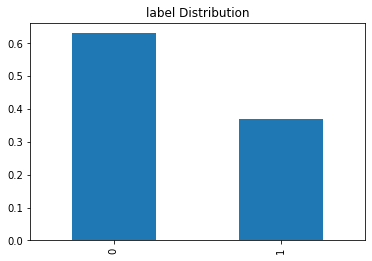

In [14]:
df.is_duplicate.value_counts(normalize=True).plot.bar()
plt.title('label Distribution');

In [15]:
print('~> Total number of question pairs for training:\n   {}'.format(len(df)))

~> Total number of question pairs for training:
   404290


In [16]:
print('~> Question pairs are not Similar (is_duplicate = 0):\n   {}%'.format(100 - round(df['is_duplicate'].mean()*100, 2)))
print('\n~> Question pairs are Similar (is_duplicate = 1):\n   {}%'.format(round(df['is_duplicate'].mean()*100, 2)))

~> Question pairs are not Similar (is_duplicate = 0):
   63.08%

~> Question pairs are Similar (is_duplicate = 1):
   36.92%


### Number of unique questions

In [17]:
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
unique_qs = len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts() > 1)
print ('Total number of  Unique Questions are: {}\n'.format(unique_qs))
#print len(np.unique(qids))

print ('Number of unique questions that appear more than one time: {} ({}%)\n'.format(qs_morethan_onetime,qs_morethan_onetime/unique_qs*100))

print ('Max number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

q_vals=qids.value_counts()

q_vals=q_vals.values

Total number of  Unique Questions are: 537933

Number of unique questions that appear more than one time: 111780 (20.77953945937505%)

Max number of times a single question is repeated: 157



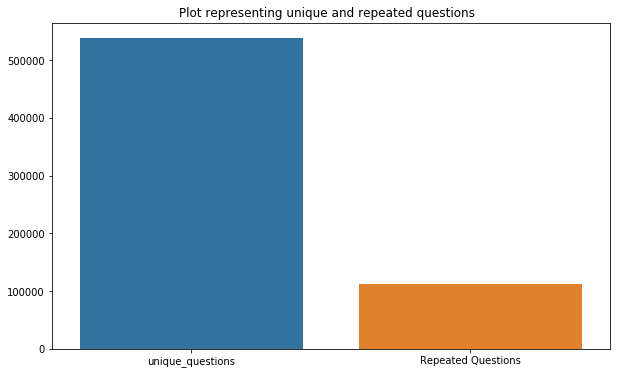

In [18]:

x = ["unique_questions" , "Repeated Questions"]
y =  [unique_qs , qs_morethan_onetime]

plt.figure(figsize=(10, 6))
plt.title ("Plot representing unique and repeated questions  ")
sns.barplot(x,y)
plt.show()

### Checking for Duplicates 

In [19]:
#checking whether there are any repeated pair of questions

pair_duplicates = df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()

print ("Number of duplicate questions",(pair_duplicates).shape[0] - df.shape[0])

Number of duplicate questions 0


### Number of occurrences of each question

Maximum number of times a single question is repeated: 157



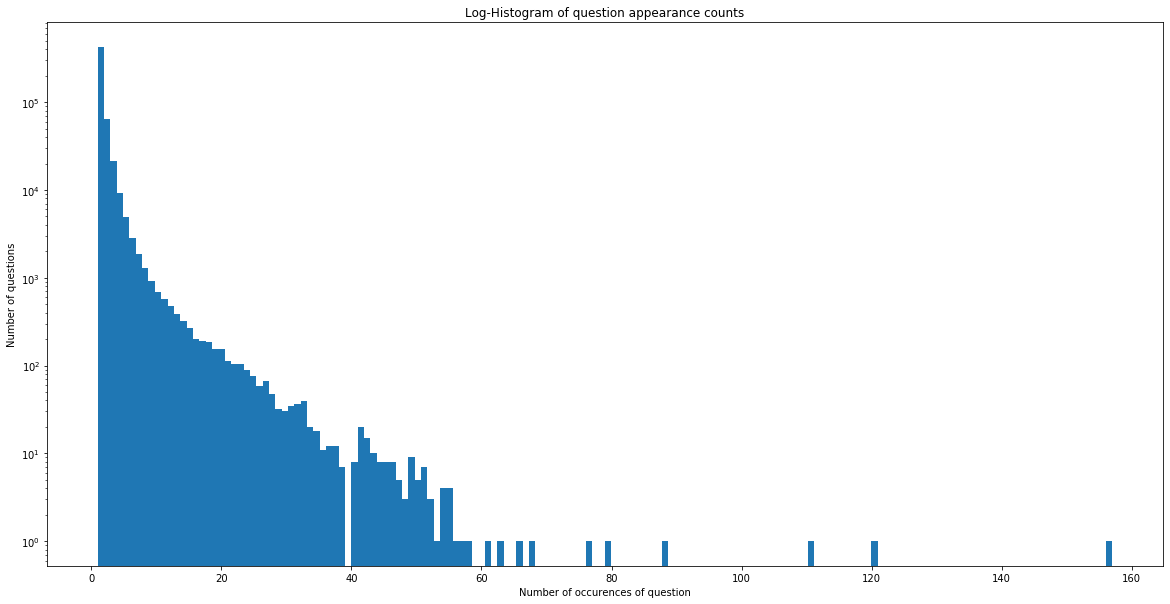

In [21]:
plt.figure(figsize=(20, 10))

plt.hist(qids.value_counts(), bins=160)

plt.yscale('log', nonposy='clip')

plt.title('Log-Histogram of question appearance counts')

plt.xlabel('Number of occurences of question')

plt.ylabel('Number of questions')

print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

### Checking for NULL values

In [22]:
#Checking whether there are any rows with null values
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

            id    qid1    qid2                         question1  \
105780  105780  174363  174364    How can I develop android app?   
201841  201841  303951  174364  How can I create an Android app?   
363362  363362  493340  493341                               NaN   

                                                question2  is_duplicate  
105780                                                NaN             0  
201841                                                NaN             0  
363362  My Chinese name is Haichao Yu. What English na...             0  


In [23]:
# Filling the null values with ' '
df = df.fillna('')
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


## Basic Feature Extraction (before cleaning)

### Features considered

Let us now construct a few features like:
 - ____freq_qid1____ = Frequency of qid1's
 - ____freq_qid2____ = Frequency of qid2's 
 - ____q1len____ = Length of q1
 - ____q2len____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
 - ____word_share____ = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2 

In [6]:
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    df = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count') 
    df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')
    df['q1len'] = df['question1'].str.len() 
    df['q2len'] = df['question2'].str.len()
    df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
    df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))

    def normalized_word_Common(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)
    df['word_Common'] = df.apply(normalized_word_Common, axis=1)

    def normalized_word_Total(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * (len(w1) + len(w2))
    df['word_Total'] = df.apply(normalized_word_Total, axis=1)

    def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
    df['word_share'] = df.apply(normalized_word_share, axis=1)

    df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
    df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])

    df.to_csv("df_fe_without_preprocessing_train.csv", index=False)

df.head()

id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2     5     6  How can I increase the speed of my internet co...   
3   3     7     8  Why am I mentally very lonely? How can I solve...   
4   4     9    10  Which one dissolve in water quikly sugar, salt...   

                                           question2  is_duplicate  freq_qid1  \
0  What is the step by step guide to invest in sh...             0          1   
1  What would happen if the Indian government sto...             0          4   
2  How can Internet speed be increased by hacking...             0          1   
3  Find the remainder when [math]23^{24}[/math] i...             0          1   
4            Which fish would survive in salt water?             0          3   

   freq_qid2  q1len  q2len  q1_n_words  q2_n_words  word_Common  word_Total  \
0          1     66     57          14          12         10.0        23.0   
1          1     51     88           8          13          4.0        20.0   
2          1     73     59          14          10          4.0        24.0   
3          1     50     65          11           9          0.0        19.0   
4          1     76     39          13           7          2.0        20.0   

   word_share  freq_q1+q2  freq_q1-q2  
0    0.434783           2           0  
1    0.200000           5           3  
2    0.166667           2           0  
3    0.000000           2           0  
4    0.100000           4           2

### Analysis of some of the extracted features 

Here are some questions have only one single words.

In [26]:
print ("Minimum length of the questions in question1 : " , min(df['q1_n_words']))

print ("Minimum length of the questions in question2 : " , min(df['q2_n_words']))

print ("Number of Questions with minimum length [question1] :", df[df['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", df[df['q2_n_words']== 1].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
Number of Questions with minimum length [question1] : 67
Number of Questions with minimum length [question2] : 24


####  Feature: word_share

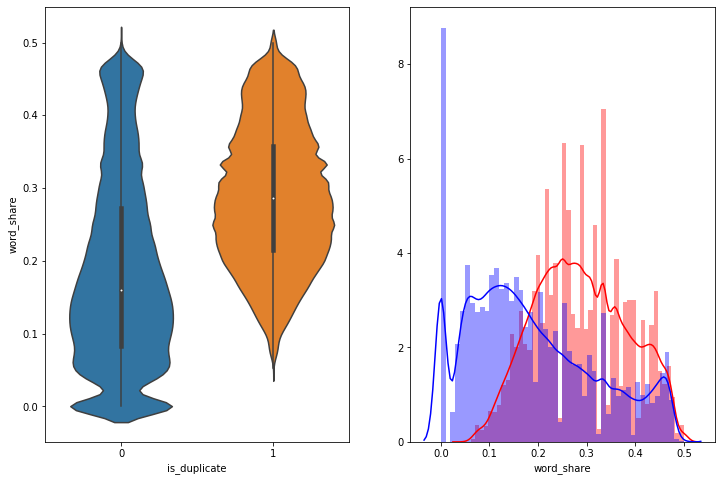

In [27]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'][0:] , label = "0" , color = 'blue' )
plt.show()

#### Feature: word_Common

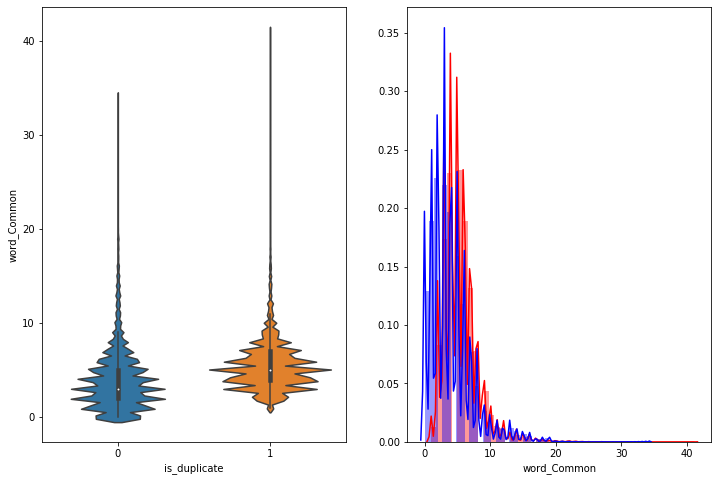

In [28]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_Common', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_Common'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_Common'][0:] , label = "0" , color = 'blue' )
plt.show()

The distributions of the word_Common feature in similar and non-similar questions are highly overlapping

## Advanced feauture engineering (fuzzy and NLP)

### NLP (based descriptive stats)

- __cwc_min__ :  Ratio of common_word_count to min lenghth of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
<br>
<br>
- __cwc_max__ :  Ratio of common_word_count to max lenghth of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
<br>
<br>
- __csc_min__ :  Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 <br> csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
<br>
<br>
- __csc_max__ :  Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2<br>csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
<br>
<br>
- __ctc_min__ :  Ratio of common_token_count to min lenghth of token count of Q1 and Q2<br>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
<br>
<br>

- __ctc_max__ :  Ratio of common_token_count to max lenghth of token count of Q1 and Q2<br>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
<br>
<br>
        
- __last_word_eq__ :  Check if First word of both questions is equal or not<br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
<br>
<br>

- __first_word_eq__ :  Check if First word of both questions is equal or not<br>first_word_eq = int(q1_tokens[0] == q2_tokens[0])
<br>
<br>
        
- __abs_len_diff__ :  Abs. length difference<br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
<br>
<br>

- __mean_len__ :  Average Token Length of both Questions<br>mean_len = (len(q1_tokens) + len(q2_tokens))/2
<br>
<br>

### Advanced fuzzy feature (based on various similartiy scores)

* Package -  https://github.com/seatgeek/fuzzywuzzy#usage
* features description - http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/

**Feature names**:

- _fuzz_ratio_ 
<br>

- _fuzz_partial_ratio_
<br>

- _token_sort_ratio_
<br>

- _token_set_ratio_
<br>

In [47]:
# To get the results in 4 decemal points
SAFE_DIV = 0.0001 

STOP_WORDS = stopwords.words("english")


def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x
    

In [45]:
def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

# get the Longest Common sub string

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(df):
    # preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    #Computing Fuzzy Features and Merging with Dataset
    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [46]:
if os.path.isfile('nlp_features_train.csv'):
    df = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
    df.fillna('')
else:
    print("Extracting features for train:")
    df = pd.read_csv("Dataset/train.csv")
    df = extract_features(df)
    df.to_csv("nlp_features_train.csv", index=False)
df.head(2)

id  qid1  qid2                                          question1  \
0   0     1     2  what is the step by step guide to invest in sh...   
1   1     3     4  what is the story of kohinoor  koh i noor  dia...   

                                           question2  is_duplicate   cwc_min  \
0  what is the step by step guide to invest in sh...             0  0.999980   
1  what would happen if the indian government sto...             0  0.799984   

    cwc_max   csc_min   csc_max  ...   ctc_max  last_word_eq  first_word_eq  \
0  0.833319  0.999983  0.999983  ...  0.785709           0.0            1.0   
1  0.399996  0.749981  0.599988  ...  0.466664           0.0            1.0   

   abs_len_diff  mean_len  token_set_ratio  token_sort_ratio  fuzz_ratio  \
0           2.0      13.0              100                93          93   
1           5.0      12.5               86                63          66   

   fuzz_partial_ratio  longest_substr_ratio  
0                 100              0.982759  
1                  75              0.596154  

[2 rows x 21 columns]

## Analysis of extracted features

### Word Clouds

In [4]:
df_duplicate = df[df['is_duplicate'] == 1]
dfp_nonduplicate = df[df['is_duplicate'] == 0]

# Converting 2d array of q1 and q2 and flatten the array: like {{1,2},{3,4}} to {1,2,3,4}
p = np.dstack([df_duplicate["question1"], df_duplicate["question2"]]).flatten()
n = np.dstack([dfp_nonduplicate["question1"], dfp_nonduplicate["question2"]]).flatten()

print ("Number of data points in class 1 (duplicate pairs) :",len(p))
print ("Number of data points in class 0 (non duplicate pairs) :",len(n))

#Saving the np array into a text file
np.savetxt('train_p.txt', p, delimiter=' ', fmt='%s')
np.savetxt('train_n.txt', n, delimiter=' ', fmt='%s')

Number of data points in class 1 (duplicate pairs) : 298526
Number of data points in class 0 (non duplicate pairs) : 510054


In [ ]:
from pathlib2 import 

In [11]:
# reading the text files and removing the Stop Words:
#d = os.path.dirname('.')

textp_w = open('train_p.txt').read()
textn_w = open('train_n.txt').read()
stopwords = set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")

stopwords.remove("no")
#stopwords.remove("good")
#stopwords.remove("love")
stopwords.remove("like")
#stopwords.remove("best")
#stopwords.remove("!")
print ("Total number of words in duplicate pair questions :",len(textp_w))
print ("Total number of words in non duplicate pair questions :",len(textn_w))

Total number of words in duplicate pair questions : 16094897
Total number of words in non duplicate pair questions : 33115322


Word Cloud for Duplicate Question pairs


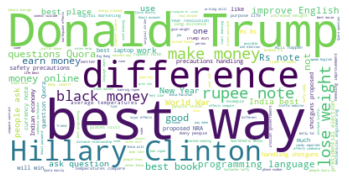

In [12]:
wc = WordCloud(background_color="white", max_words=len(textp_w), stopwords=stopwords)
wc.generate(textp_w)
print ("Word Cloud for Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

Word Cloud for non-Duplicate Question pairs:


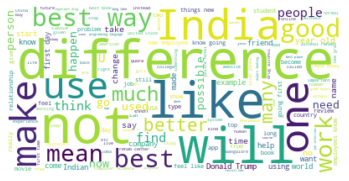

In [13]:
wc = WordCloud(background_color="white", max_words=len(textn_w),stopwords=stopwords)
# generate word cloud
wc.generate(textn_w)
print ("Word Cloud for non-Duplicate Question pairs:")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

 ### Pair plot of features ['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio']

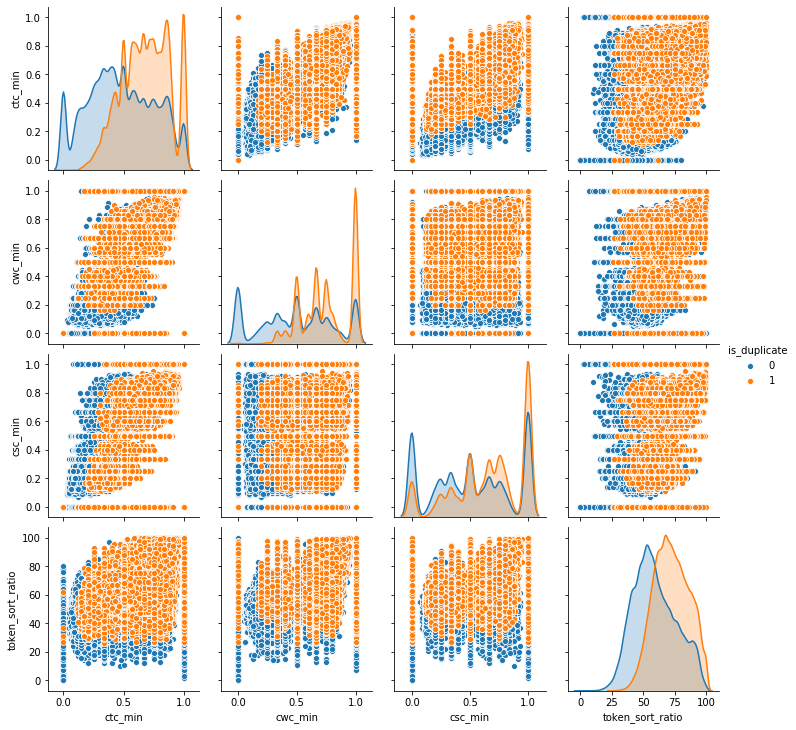

In [29]:
n = df.shape[0]
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

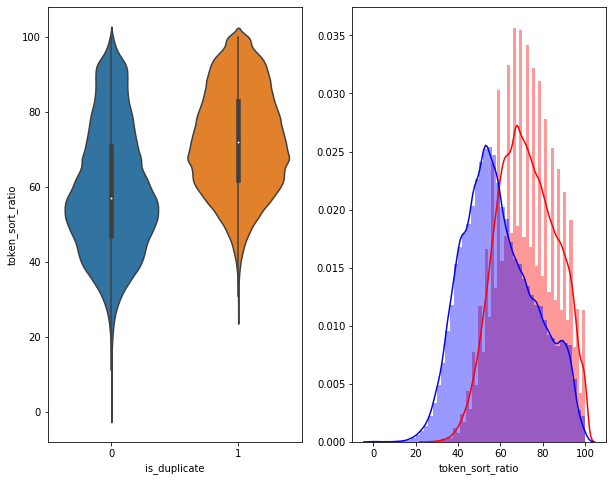

In [48]:
# Distribution of the token_sort_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

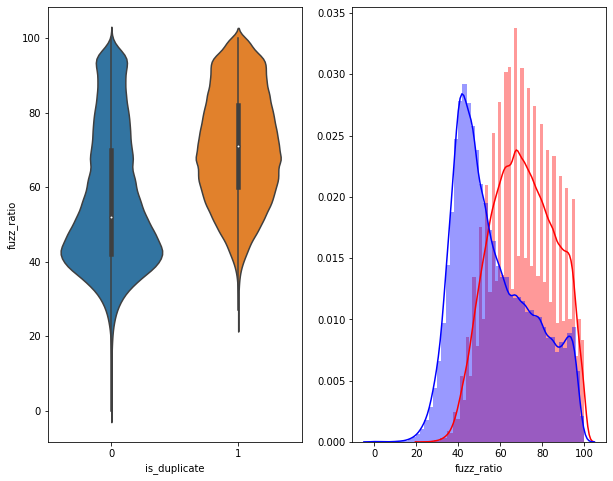

In [31]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['fuzz_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['fuzz_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

## Visualization 

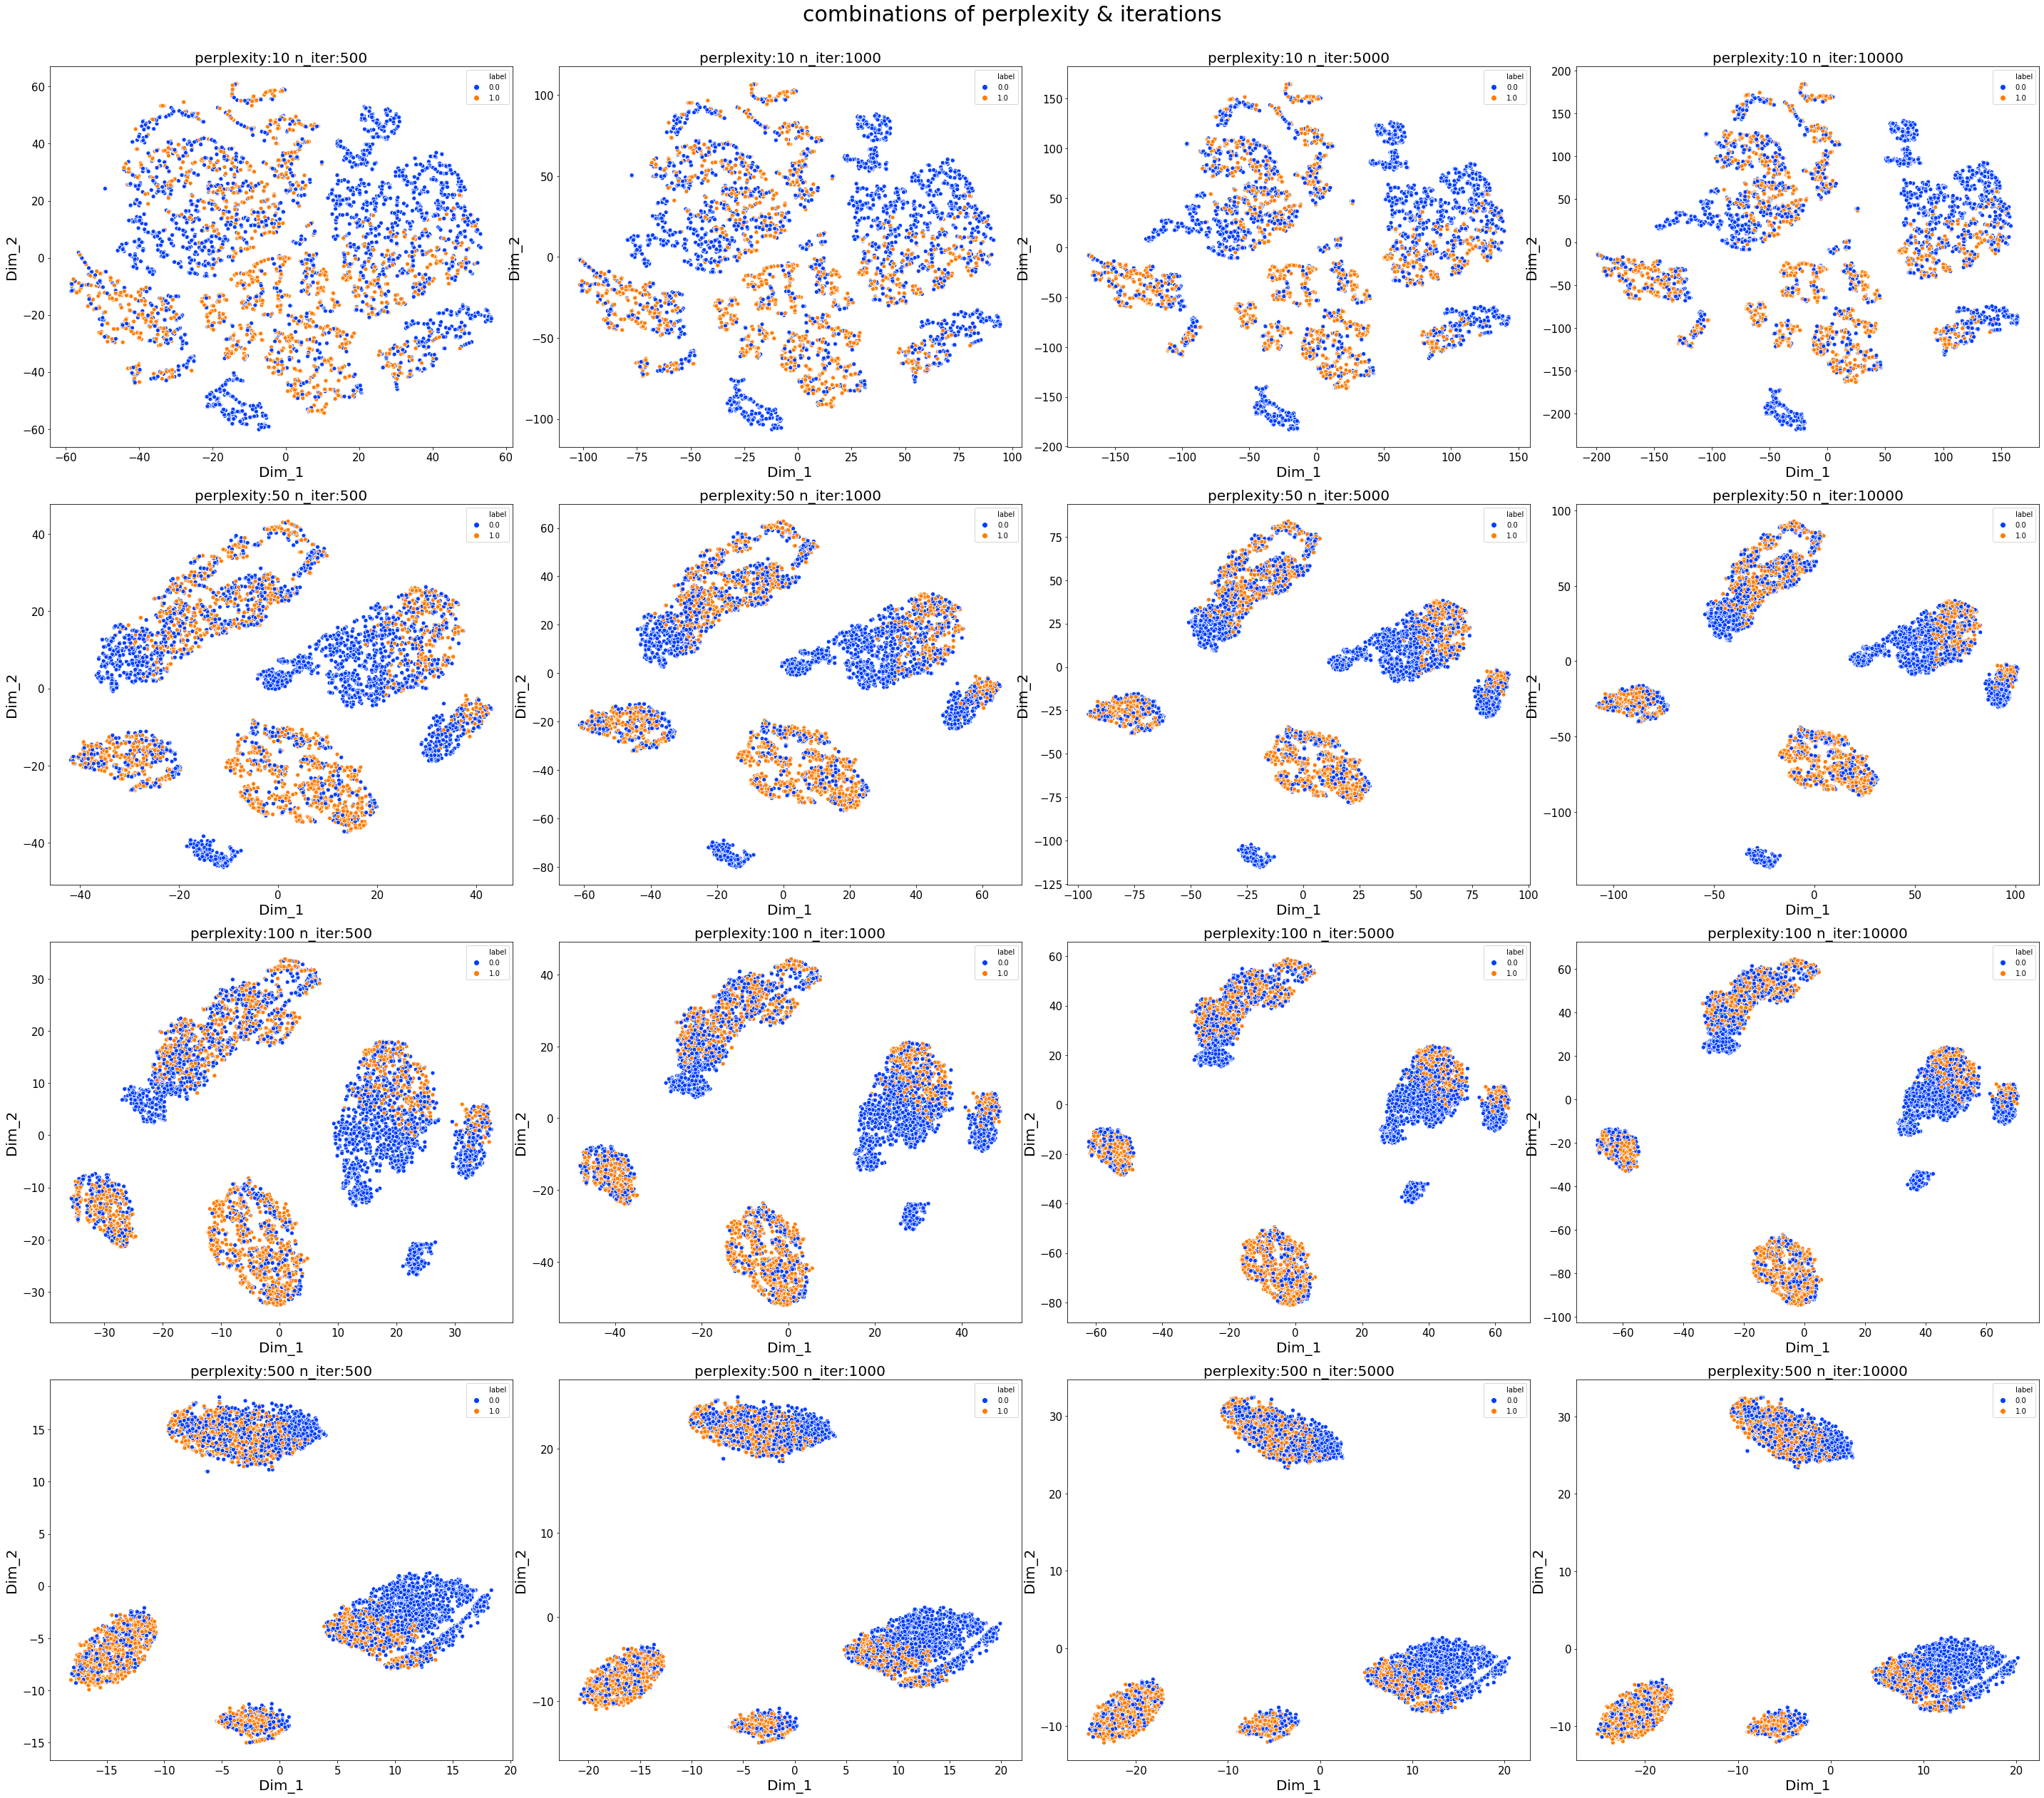

In [51]:
# Using TSNE for Dimentionality reduction for 15 Features(Generated after cleaning the data) to 3 dimention

from sklearn.preprocessing import MinMaxScaler
from tqdm.notebook import tqdm
import itertools

param = {'perplexity':[10,50,100,500],'n_iter':[500,1000,5000,10000]}

fig,axes = plt.subplots(4,4,figsize=(50,40))#,sharex='all', sharey='all')
fig.subplots_adjust(wspace=0.1, hspace=0.15, top=0.95)
fig.suptitle('combinations of perplexity & iterations', fontsize=30)
axes = axes.ravel()


keys, values = zip(*param.items())
param_list = [dict(zip(keys, v)) for v in itertools.product(*values)]

dfp_subsampled = df[0:5000]
X = MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = dfp_subsampled['is_duplicate'].values

for i,param in tqdm(enumerate(param_list)):
    model = TSNE(n_components=2, random_state=0,**param)
    tsne_data = model.fit_transform(X)
    tsne_data = np.vstack((tsne_data.T,y)).T
    
    tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
    
    sns.scatterplot(x='Dim_1',y='Dim_2',hue="label",data=tsne_df,sizes =6, palette=sns.color_palette("bright", 2),ax = axes[i])
    axes[i].set_title(f"perplexity:{param['perplexity']} n_iter:{param['n_iter']}",fontsize=20)
    axes[i].set_xlabel("Dim_1",fontsize=20)
    axes[i].set_ylabel("Dim_2",fontsize=20)
    axes[i].tick_params(labelsize=15)

There exists some separatability between two features which means our features have impact on separtion 

## Mean TF-IDF W2V features

### TF-IDF model train

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

df.fillna('', inplace=True)
# merge texts
questions = list(df['question1']) + list(df['question2'])

tfidf = TfidfVectorizer(lowercase=False)
tfidf.fit(questions);
tfidf_dict = dict(zip(tfidf.get_feature_names(), list(tfidf.idf_)))

## Data Pipeline

In [4]:
data_pos = df[df["is_duplicate"] == 1].sample(n = 50000) #50000
data_neg = df[df["is_duplicate"] == 0].sample(n = 50000) #50000
final_100k = pd.concat([data_pos, data_neg])

X = final_100k.drop('is_duplicate', axis=1)
Y = final_100k.is_duplicate

### Featurization pipeline

#### Simple TFIDF 

In [20]:
clf = Pipeline([
    ('fill_na', Pipeline([
        ('fill_null',Text_FillNa(fill_value=''))])),
    ('features',FeatureUnion([
        ('numerics_stats', Pipeline([('summerize',Text_SimStats())])),
        ('NLP_vectorize',Pipeline([
            ('extract',ColumnExtractor(['question1','question2'])),
            ('preprocess', Quora_TextPreprocess()),
            ('nlp_features',DF_NLP_extract())])),
        ('Fuzzy_vectorize',Pipeline([
            ('extract',ColumnExtractor(['question1','question2'])),
            ('preprocess', Quora_TextPreprocess()),
            ('fuzzy_features',DF_fuzzySimExtract())])),
        ('TFIDF_vectorizer',Pipeline([
            ('extract',ColumnExtractor(['question1','question2'])),
            ('combine',Converter()),
            ('TFIDF_wv_features',TfidfVectorizer(ngram_range=(1,2)))]))
        ]))])

X_tfidf = clf.fit_transform(X)
TFIDF_Pipleline_TransformedData = train_test_split(X_tfidf,Y,test_size=0.3,random_state=0)

In [21]:
with open('TFIDF_Pipleline_TransformedData.pkl', 'wb') as f:
    pickle.dump(TFIDF_Pipleline_TransformedData, f, protocol=pickle.HIGHEST_PROTOCOL)

In [5]:
with open('TFIDF_Pipleline_TransformedData.pkl', 'rb') as f:
    TFIDF_X_train,TFIDF_X_test,y_train,y_test  = pickle.load(f)

#### TFIDF Word2Vec

In [23]:
clf = Pipeline([
    ('fill_na', Pipeline([
        ('fill_null',Text_FillNa(fill_value=''))])),
    ('features',FeatureUnion([
        ('numerics_stats', Pipeline([('summerize',Text_SimStats())])),
        ('NLP_vectorize',Pipeline([
            ('extract',ColumnExtractor(['question1','question2'])),
            ('preprocess', Quora_TextPreprocess()),
            ('nlp_features',DF_NLP_extract())])),
        ('Fuzzy_vectorize',Pipeline([
            ('extract',ColumnExtractor(['question1','question2'])),
            ('preprocess', Quora_TextPreprocess()),
            ('fuzzy_features',DF_fuzzySimExtract())])),
        ('TFIDF_vectorizer',Pipeline([
            ('extract',ColumnExtractor(['question1','question2'])),
            ('TFIDF_wv_features',TFIDF_WV_transformer(TFIDF_dict = tfidf_dict))]))
        ]))])

X_tfidfwv = clf.fit_transform(X)
TFIDF_WV_Pipleline_TransformedData = train_test_split(X_tfidfwv,Y,test_size=0.3,random_state=0)

In [24]:
with open('TFIDF_WV_Pipleline_TransformedData.pkl', 'wb') as f:
    pickle.dump(TFIDF_WV_Pipleline_TransformedData, f, protocol=pickle.HIGHEST_PROTOCOL)

In [6]:
with open('TFIDF_WV_Pipleline_TransformedData.pkl', 'rb') as f:
    TFIDF_WV_X_train,TFIDF_WV_X_test,y_train,y_test = pickle.load(f)

## Model Building

In [24]:
# confusion matrix
def plot_confusion_matrix(X_test,test_y,model = None, param = None ):
    
    sns.set()
    # cv results to dataframe 
    results = pd.DataFrame(model.cv_results_)

    mean_train_score = results.groupby(f'param_base_estimator__{param}')['mean_train_score'].max()
    mean_test_score = results.groupby(f'param_base_estimator__{param}')['mean_test_score'].max()

    plt.figure(figsize=(25,20))

    # Hyper parameter plot 
    plt.subplot(221)
    plt.xscale('log')
    sns.lineplot(mean_train_score.index,mean_train_score)
    sns.lineplot(mean_test_score.index,mean_test_score)

    sns.scatterplot(mean_train_score.index,mean_train_score)
    sns.scatterplot(mean_test_score.index,mean_test_score)
    max_ind = mean_test_score.argmax()
    sns.scatterplot([mean_test_score.index[max_ind]],[mean_test_score.values[max_ind]],s=100)

    plt.xlabel(param)
    plt.ylabel("Log loss")
    plt.title(f"Validation (best {param}: {mean_test_score.index[max_ind]}, best score:  {round(mean_test_score.values[max_ind],3)})");
    
    
    C = confusion_matrix(test_y, model.predict(X_test))
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))
    
    
    labels = [1,2]
    # representing A in heatmap format
    plt.subplot(222)
    cmat = C.astype(int)
    sns.heatmap(cmat, annot=True,  fmt=".0f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title(f"Confusion Matrix [Accuracy: {round(accuracy_score(test_y, model.predict(X_test)),2)}]")
    
    plt.subplot(223)
    sns.heatmap(B, annot=True, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(224)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()
    


### Random Model - BenchMark or worst-case log-loss

Log loss on Test Data using Random Model 0.8761258580327818


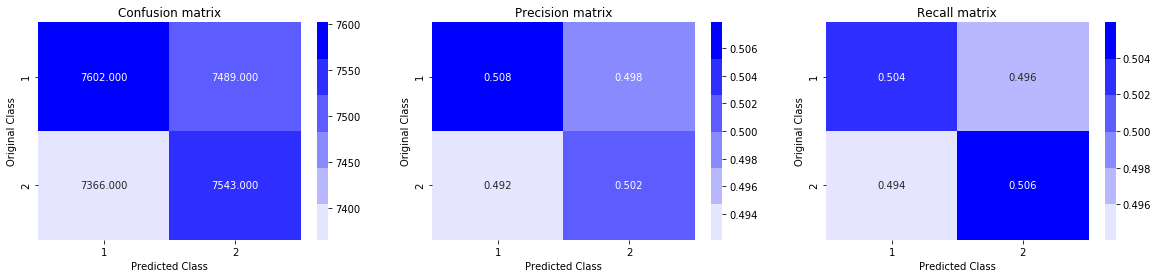

In [39]:
predicted_y = np.zeros((len(Y_test),2))
for i in range(len(Y_test)):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(Y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(Y_test, predicted_y)

## Model Selection

Since we feature dimesion mid-rage (not too high ~1000's and not too low <30). we can also try Tree based algorithms along with LR ans Linear SVM.

Since our focus is on optimizing for log_loss (associated with p) we should calibrate our model which tries to match p with thwe confidence

### Logistic Regression

#### Logistic Regression with simple TFIDF features

In [47]:
param_grid = {'base_estimator__alpha':[10 ** x for x in range(-5, 2)],
             'base_estimator__penalty': ['l1','l2']}

cv_1 = ShuffleSplit(test_size=0.20, n_splits=1, random_state=0)
base_estimator = SGDClassifier(loss='log',random_state=42)

model = GridSearchCV(CalibratedClassifierCV(base_estimator = base_estimator),
                     cv=5,scoring='neg_log_loss',
                     n_jobs = 6,
                     param_grid = param_grid,
                     return_train_score=True,
                     verbose=1)

model.fit(TFIDF_X_train,y_train);

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed: 15.8min
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed: 17.0min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=0.0001,
                                                                           average=False,
                                                                           class_weight=None,
                                                                           early_stopping=False,
                                                                           epsilon=0.1,
                                                                           eta0=0.0,
                                                                           fit_intercept=True,
                                                                           l1_ratio=0.15,
                                                                           learning_rate='optimal',
                                                                           loss='log',
                                                 

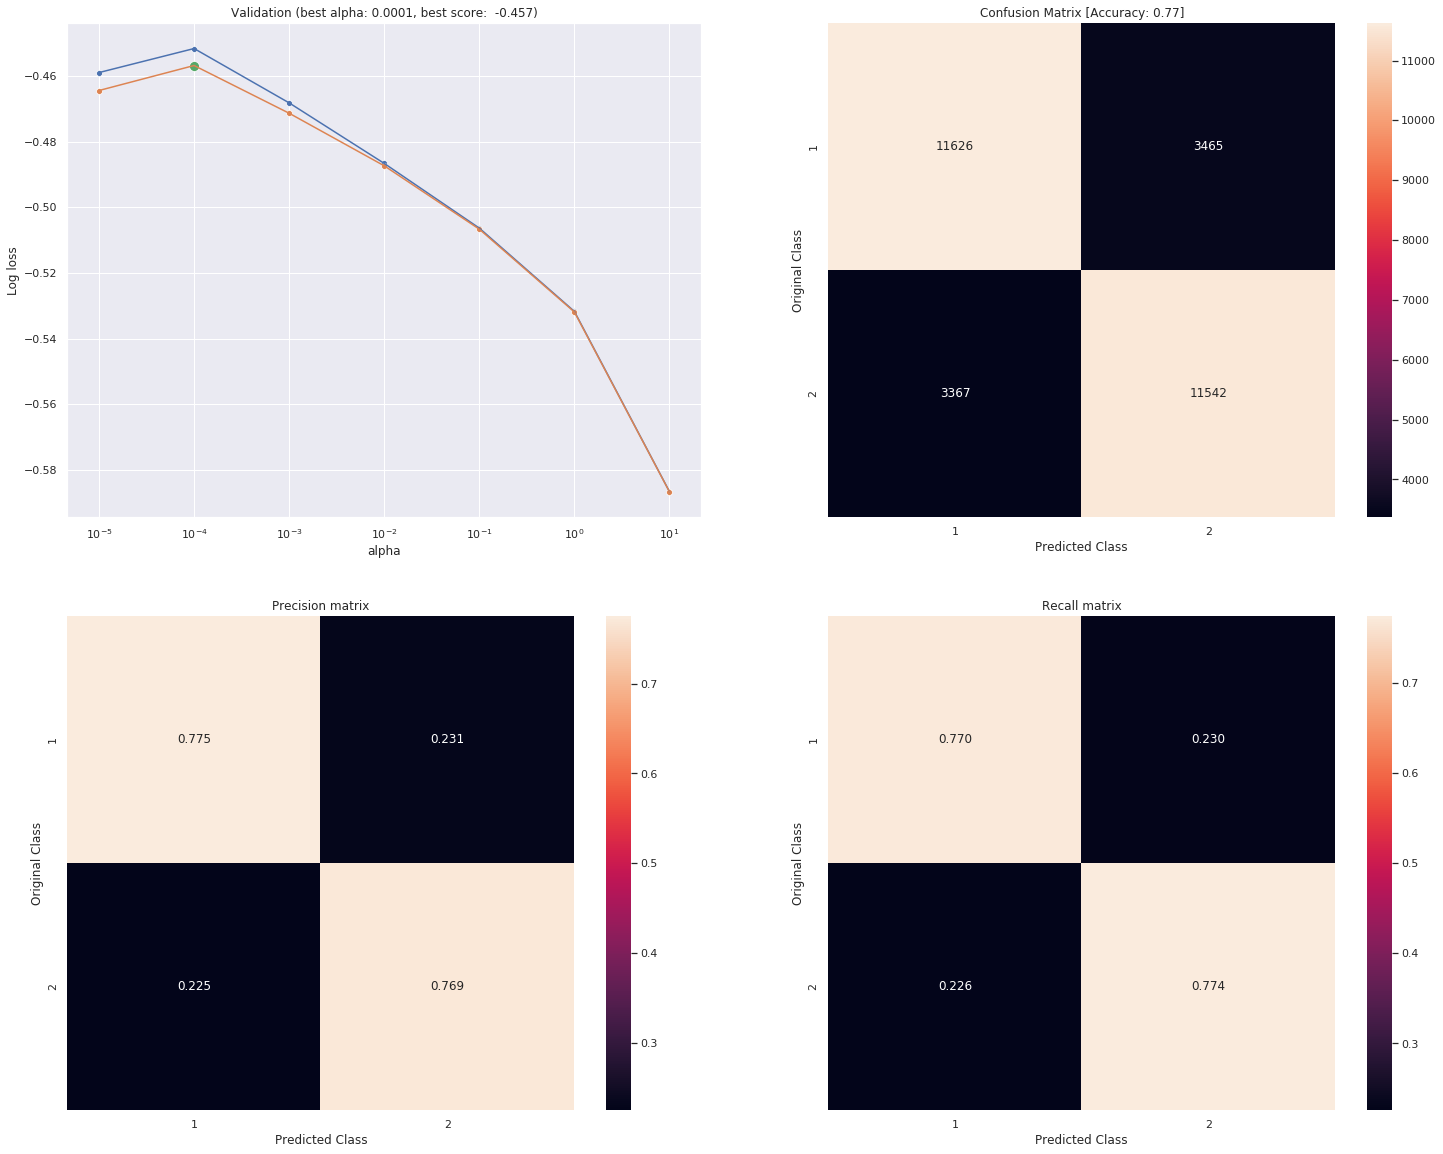

In [85]:
plot_confusion_matrix(TFIDF_X_test,y_test,model = model, param = 'alpha')

In [86]:
model.best_params_

{'base_estimator__alpha': 0.0001, 'base_estimator__penalty': 'l2'}

#### Logistic Regression with TFIDF WV features

In [87]:
param_grid = {'base_estimator__alpha':[10 ** x for x in range(-5, 2)],
             'base_estimator__penalty': ['l1','l2']}

cv_1 = ShuffleSplit(test_size=0.20, n_splits=1, random_state=0)
base_estimator = SGDClassifier(loss='log',random_state=42)

model = GridSearchCV(CalibratedClassifierCV(base_estimator = base_estimator),
                     cv=5,scoring='neg_log_loss',
                     n_jobs = 6,
                     param_grid = param_grid,
                     return_train_score=True,
                     verbose=1)

model.fit(TFIDF_WV_X_train,y_train);

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed: 18.2min
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed: 27.7min finished


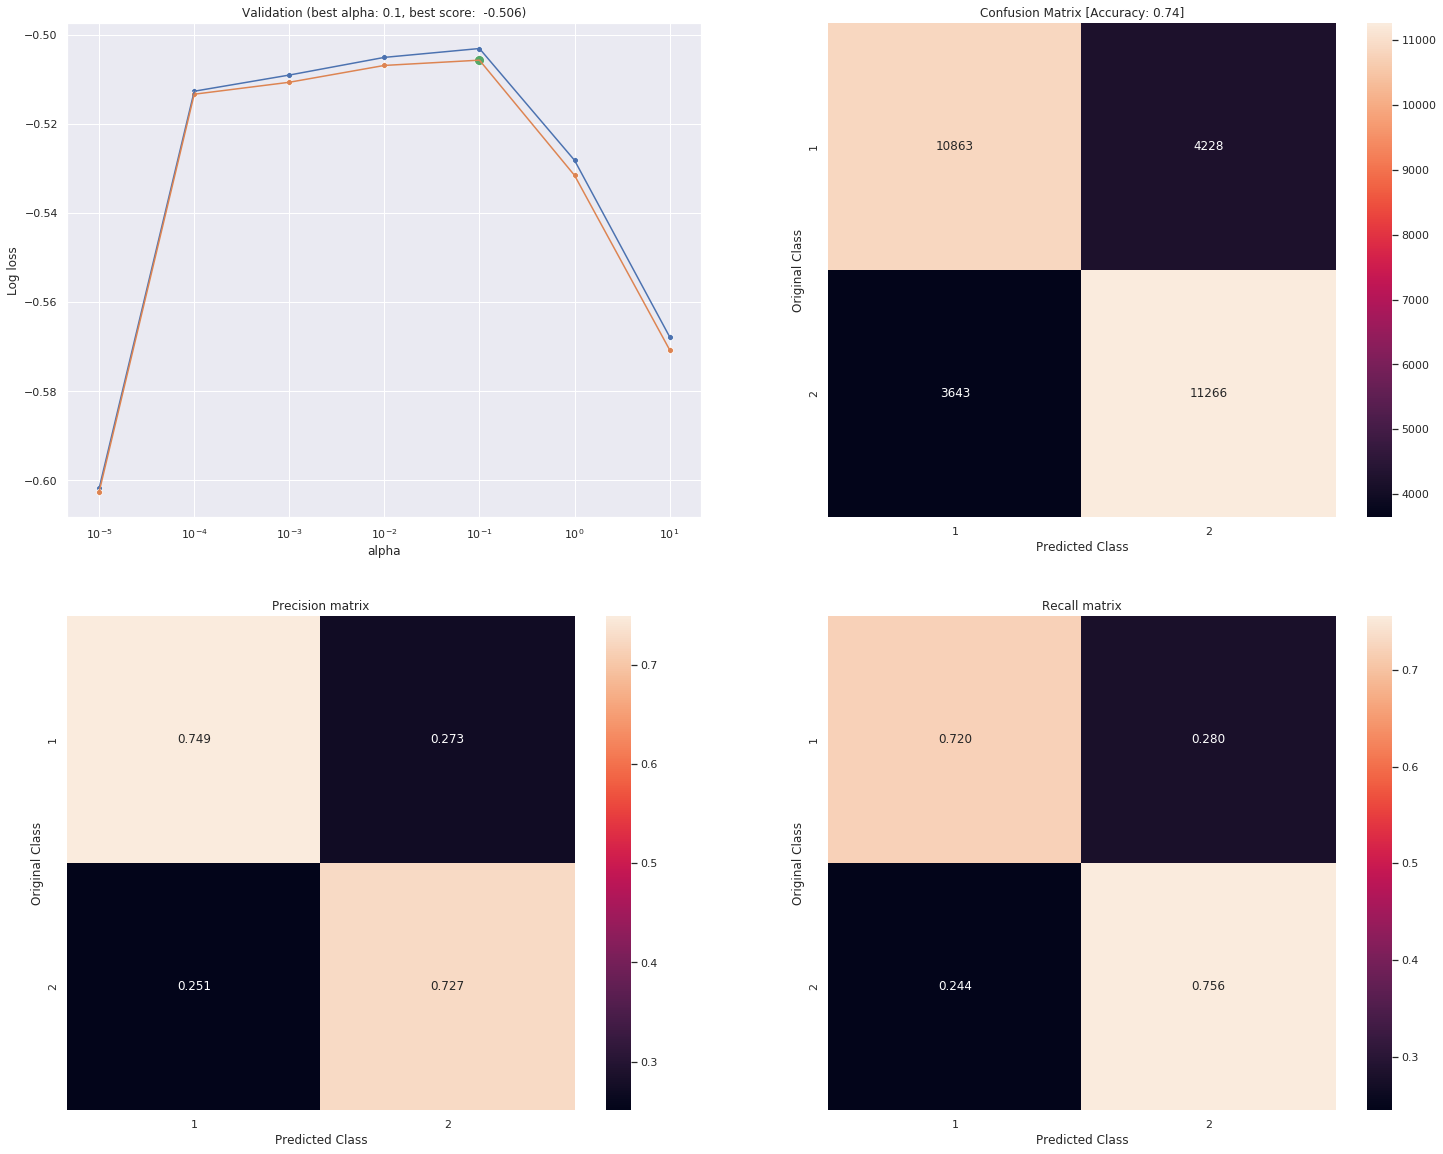

In [88]:
plot_confusion_matrix(TFIDF_WV_X_test,y_test,model = model, param = 'alpha')

In [89]:
model.best_params_

{'base_estimator__alpha': 0.1, 'base_estimator__penalty': 'l2'}

### SVM

#### SVM with simple TFIDF features

In [90]:
param_grid = {'base_estimator__alpha':[10 ** x for x in range(-5, 2)],
             'base_estimator__penalty': ['l1','l2']}

cv_1 = ShuffleSplit(test_size=0.20, n_splits=1, random_state=0)
base_estimator = SGDClassifier(loss='hinge',random_state=42)

model = GridSearchCV(CalibratedClassifierCV(base_estimator = base_estimator),
                     cv=5,scoring='neg_log_loss',
                     n_jobs = 6,
                     param_grid = param_grid,
                     return_train_score=True,
                     verbose=1)

model.fit(TFIDF_X_train,y_train);

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed: 13.5min
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed: 14.4min finished


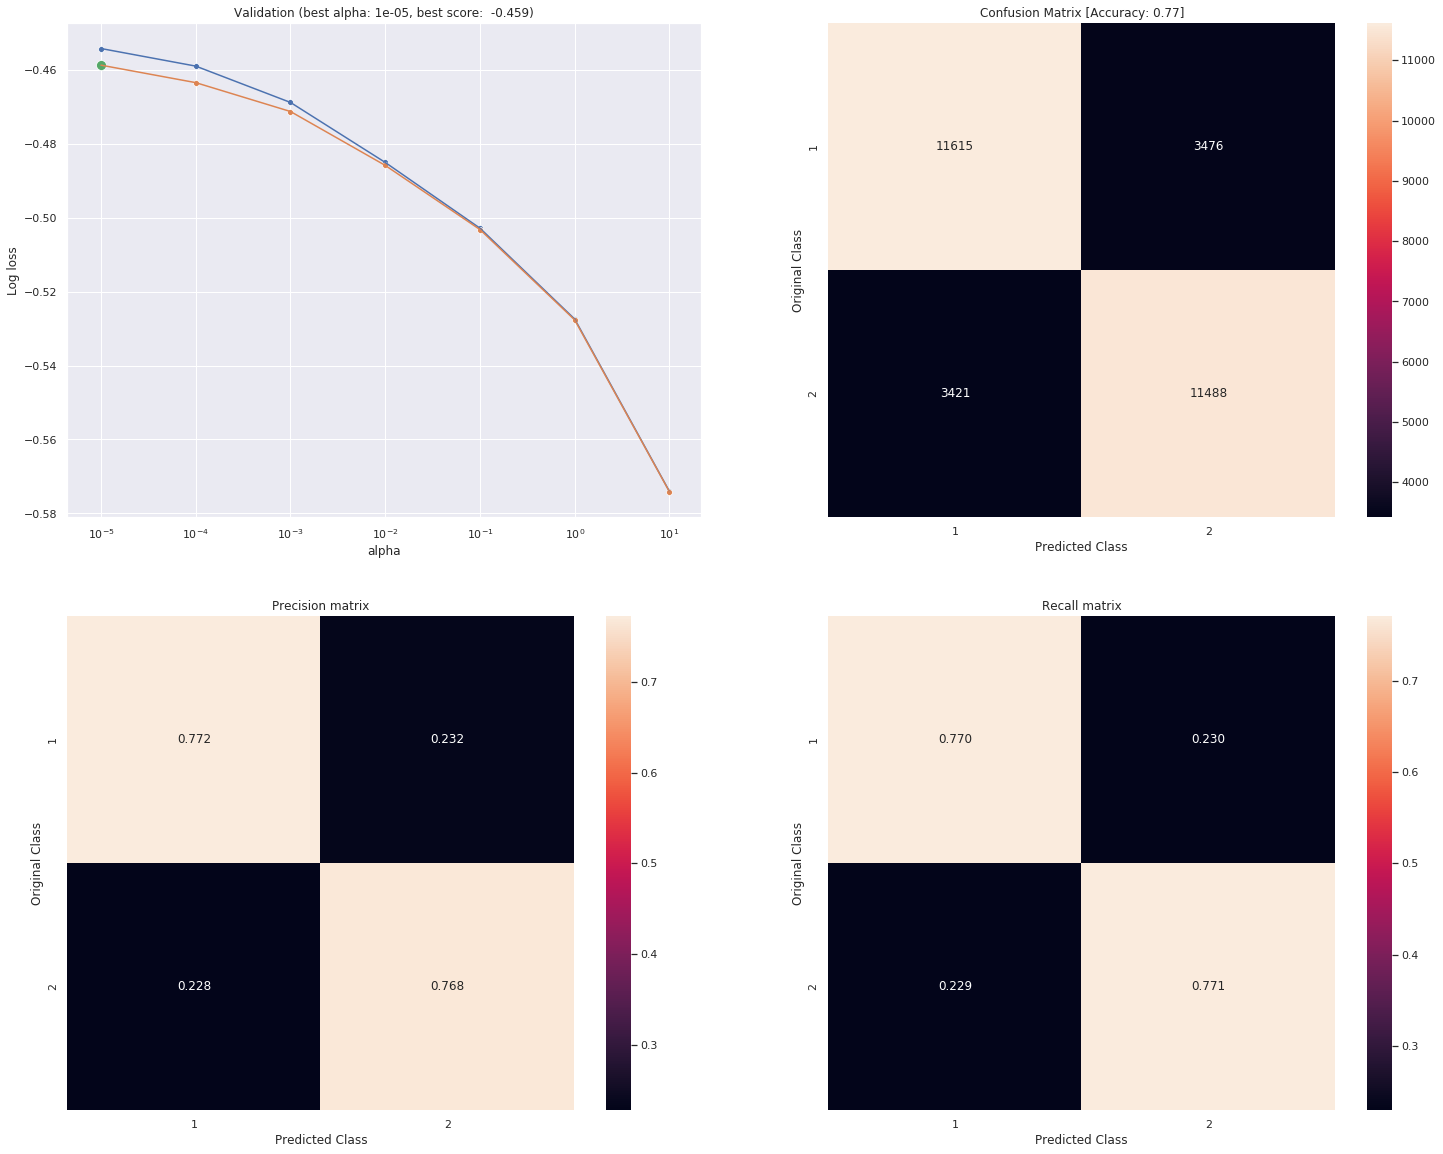

In [91]:
plot_confusion_matrix(TFIDF_X_test,y_test,model = model, param = 'alpha')

In [92]:
model.best_params_

{'base_estimator__alpha': 1e-05, 'base_estimator__penalty': 'l2'}

#### SVM Regression with TFIDF WV features

In [93]:
param_grid = {'base_estimator__alpha':[10 ** x for x in range(-5, 2)],
             'base_estimator__penalty': ['l1','l2']}

cv_1 = ShuffleSplit(test_size=0.20, n_splits=1, random_state=0)
base_estimator = SGDClassifier(loss='hinge',random_state=42)

model = GridSearchCV(CalibratedClassifierCV(base_estimator = base_estimator),
                     cv=5,scoring='neg_log_loss',
                     n_jobs = 6,
                     param_grid = param_grid,
                     return_train_score=True,
                     verbose=1)

model.fit(TFIDF_WV_X_train,y_train);

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed: 17.0min
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed: 31.9min finished


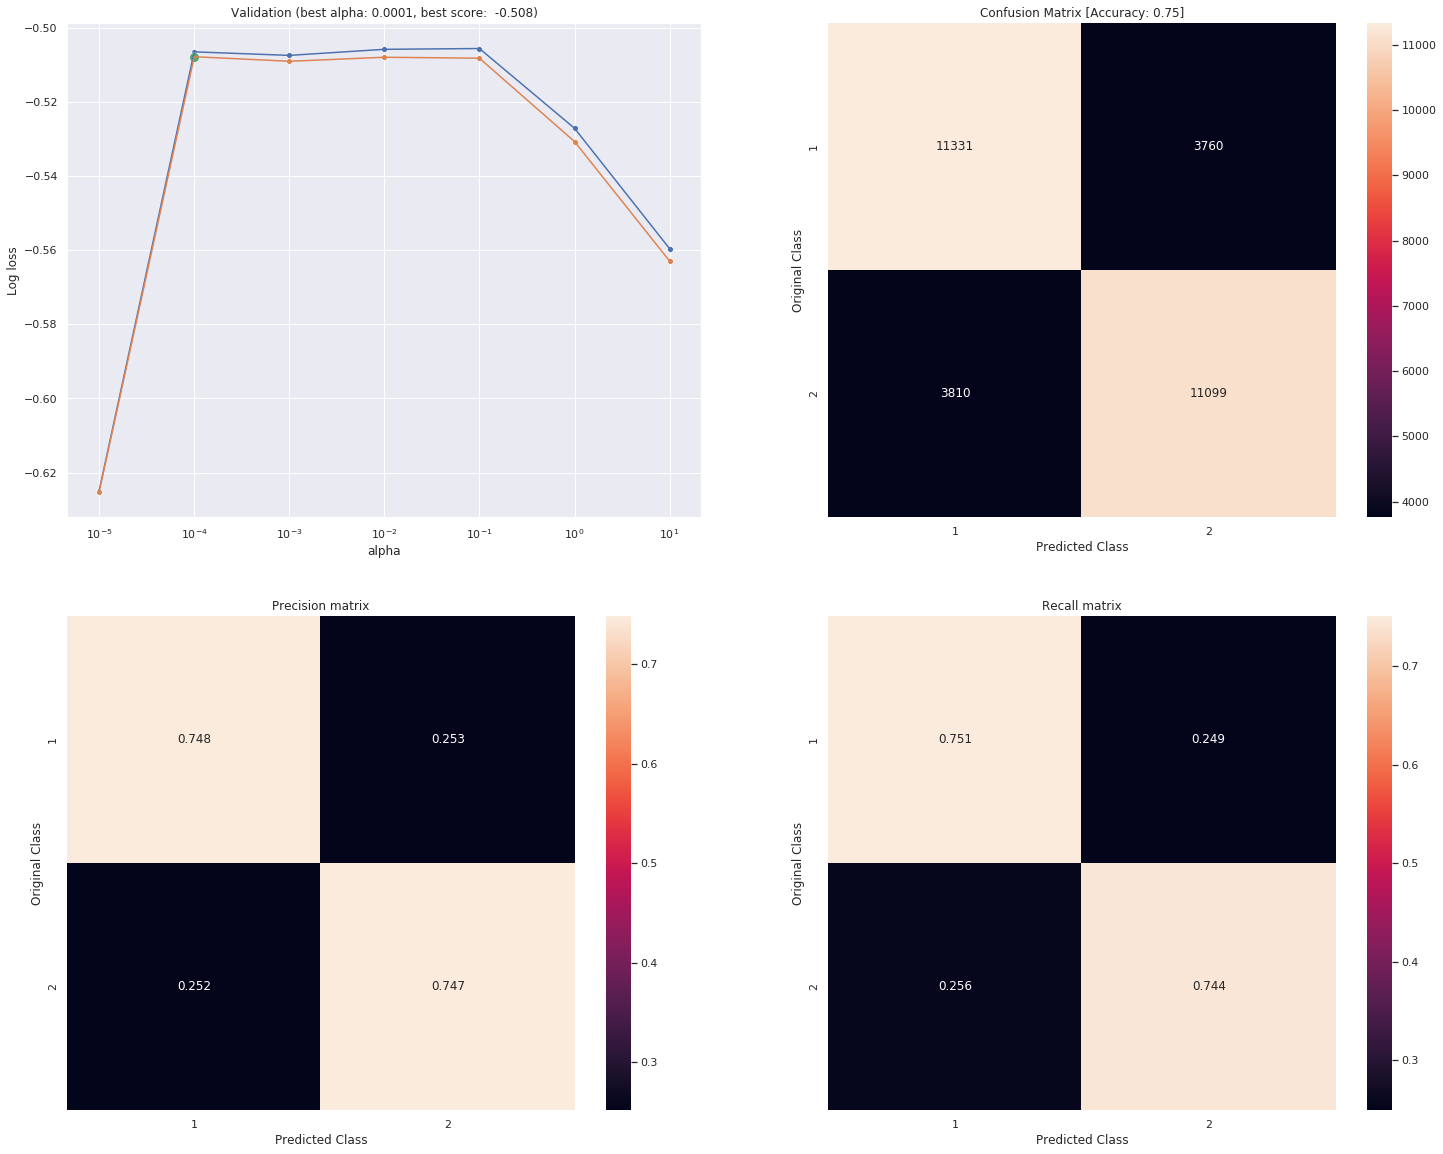

In [94]:
plot_confusion_matrix(TFIDF_WV_X_test, y_test, model=model, param='alpha')

In [95]:
model.best_params_

{'base_estimator__alpha': 0.0001, 'base_estimator__penalty': 'l2'}

### XGBoost

#### XGBoost with simple TFIDF features

In [16]:
from xgboost.sklearn import XGBClassifier

In [26]:
fixed_params = dict(max_depth=5,
                    min_child_weight=1,
                    gamma=0,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    learning_rate=0.1,
                    scale_pos_weight=1)

param_grid = {
    'base_estimator__n_estimators': [50,100,150,250,500]
}

base_estimator = XGBClassifier(objective='binary:logistic', **fixed_params)

model = GridSearchCV(CalibratedClassifierCV(base_estimator=base_estimator),
                     cv=5,
                     scoring='neg_log_loss',
                     n_jobs=6,
                     param_grid=param_grid,
                     return_train_score=True,
                     verbose=1)

model.fit(TFIDF_X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  25 out of  25 | elapsed: 41.9min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=CalibratedClassifierCV(base_estimator=XGBClassifier(base_score=None,
                                                                           booster=None,
                                                                           colsample_bylevel=None,
                                                                           colsample_bynode=None,
                                                                           colsample_bytree=0.8,
                                                                           gamma=0,
                                                                           gpu_id=None,
                                                                           importance_type='gain',
                                                                           interaction_constraints=None,
                                                                           learning_rate=0.1,
                   

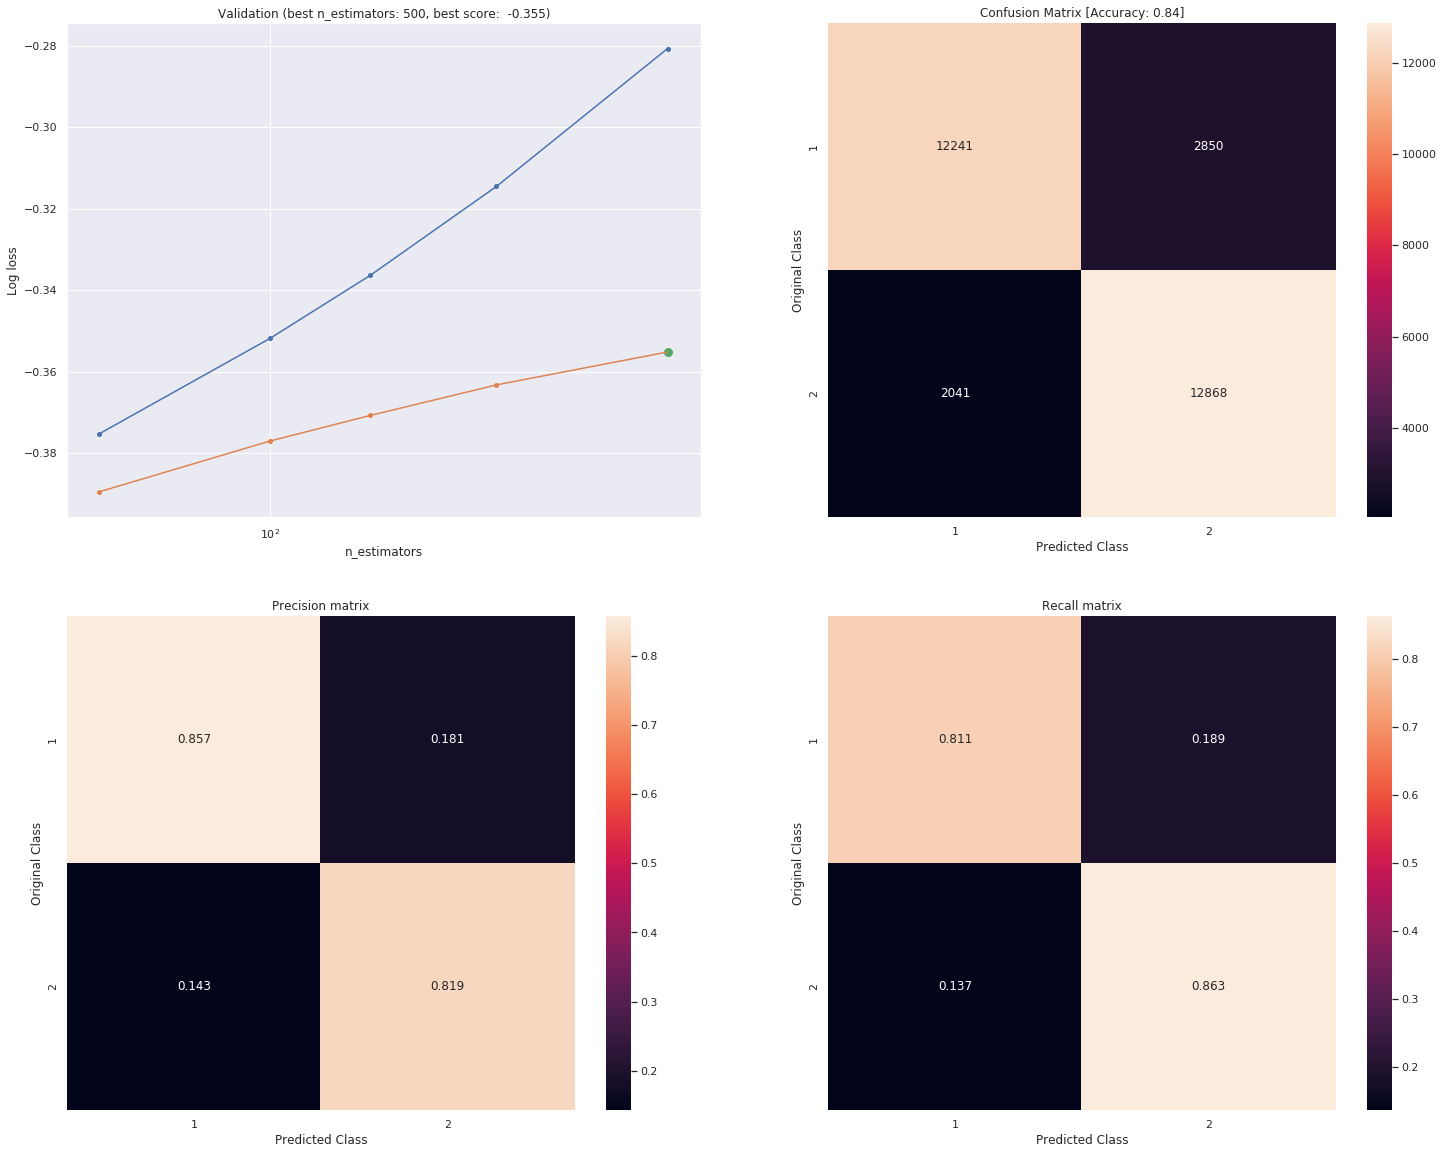

In [28]:
plot_confusion_matrix(TFIDF_X_test,y_test,model = model, param = 'n_estimators')

In [92]:
model.best_params_

{'base_estimator__alpha': 1e-05, 'base_estimator__penalty': 'l2'}